# Getting started: MPC

Let's learn MPC


In [63]:
import numpy as np
import do_mpc

In [64]:
model_type = 'continuous'
model = do_mpc.model.Model(model_type)

In [65]:
z = model.set_variable(var_type='_x', var_name='z', shape=(1,1))
zd = model.set_variable(var_type='_x', var_name='zd', shape=(1,1))
t = model.set_variable(var_type='_u', var_name='t', shape=(1,1))
m = model.set_variable(var_type='_p', var_name='m', shape=(1,1))
k = model.set_variable(var_type='_p', var_name='k', shape=(1,1))
rho = model.set_variable(var_type='_p', var_name='rho', shape=(1,1))
v = model.set_variable(var_type='_p', var_name='v', shape=(1,1))
g = 9.81

In [66]:
model.set_rhs('z', zd)
model.set_rhs('zd', ( (rho * v - m) * g - k * zd + t ) / m)

In [67]:
model.setup()

In [68]:
mpc = do_mpc.controller.MPC(model)

In [69]:
setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 1,
    'store_full_solution': True
}
mpc.set_param(**setup_mpc)

In [70]:
mterm = z**2 + zd **2
lterm = z**2 + zd **2
mpc.set_objective(mterm=mterm, lterm=lterm)

In [71]:
mpc.set_rterm(t=1e-2)

In [72]:
mpc.bounds['lower', '_x', 'z'] = -1000
mpc.bounds['upper', '_x', 'z'] = 1000
mpc.bounds['lower', '_x', 'zd'] = -5
mpc.bounds['upper', '_x', 'zd'] = 5
mpc.bounds['lower', '_u', 't'] = -10
mpc.bounds['upper', '_u', 't'] = 10

In [73]:
mass = 50 * np.array([1., 0.9, 1.1])
drag = 20 * np.array([1., 2., 0.5])
density = 1000 * np.array([1., 1.03, 0.98])
vol = 0.051 * np.array([1.])

mpc.set_uncertainty_values(
    m=mass,
    k=drag,
    rho=density,
    v=vol
)

In [74]:
mpc.setup()

In [75]:
simulator = do_mpc.simulator.Simulator(model)

simulator.set_param(t_step=0.1)

p_template = simulator.get_p_template()

def p_fun(t_now):
    p_template['m'] = 50
    p_template['k'] = 20
    p_template['rho'] = 1000
    p_template['v'] = 0.051
    return p_template

simulator.set_p_fun(p_fun)
simulator.setup()

In [76]:
x0 = np.array([0, 0])
simulator.x0 = x0
mpc.x0 = x0

In [77]:
mpc.set_initial_guess()

In [78]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

In [79]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [80]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [81]:
%%capture
for g in [sim_graphics, mpc_graphics]:
    # Plot the position and vel (z, zd) on the first axis:
    g.add_line(var_type='_x', var_name='z', axis=ax[0])
    g.add_line(var_type='_x', var_name='zd', axis=ax[0])

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name='t', axis=ax[1])

ax[0].set_ylabel('position [m] and speed [m/s]')
ax[1].set_ylabel('thrust [N]')
ax[1].set_xlabel('time [s]')

In [82]:
u0 = np.zeros((1,1))
for i in range(200):
    simulator.make_step(u0)

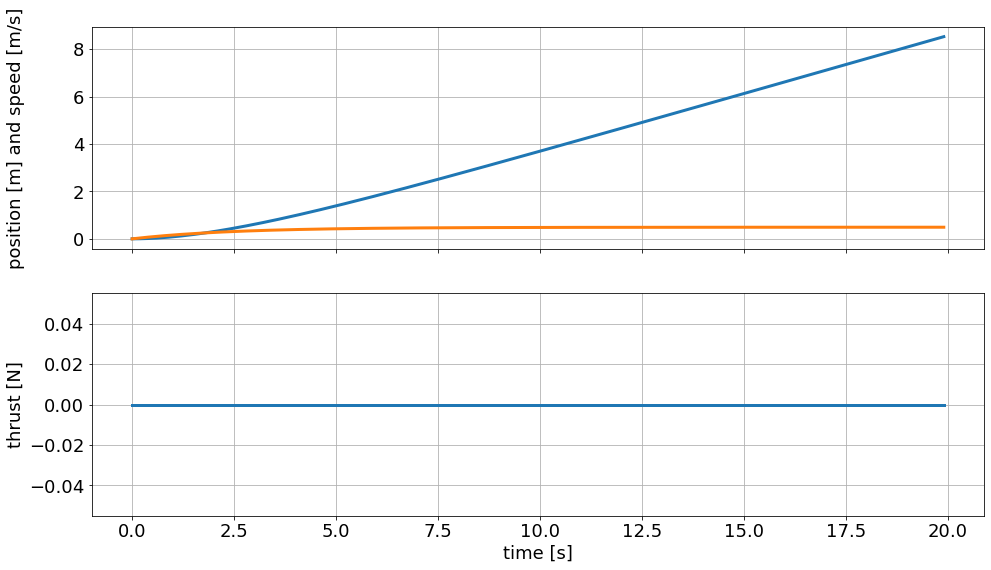

In [83]:
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
# Show the figure:
fig

In [84]:
u0 = mpc.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    12962
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2109

Total number of variables............................:     5076
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     4644
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4322
Total number of inequality c

In [85]:
sim_graphics.clear()

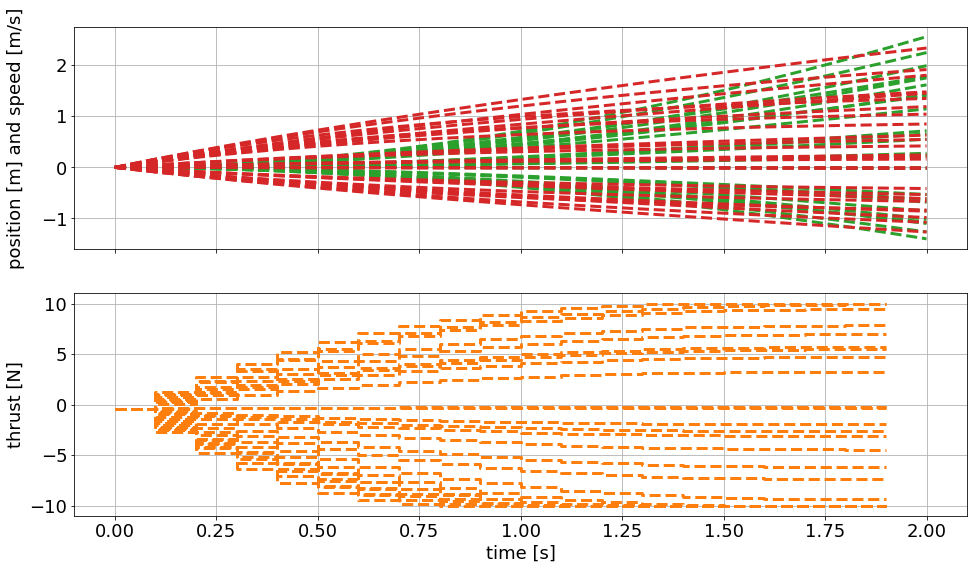

In [86]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig

In [87]:
mpc_graphics.pred_lines

In [88]:
simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()

In [91]:
%%capture
for i in range(20):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)
# Plot predictions from t=0
mpc_graphics.plot_predictions(t_ind=0)
# Plot results until current time
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig

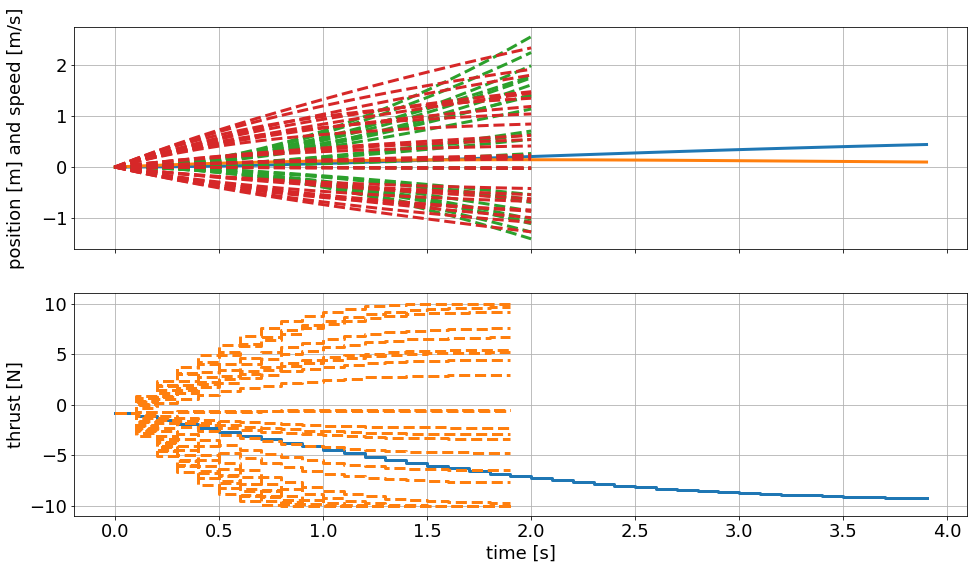

In [92]:
fig